# Compute projections
Best options is to run `iss project-round` command after each acquisition:

`iss project-round -p $PATH -n $PREFIX`

where `$PATH` is the path to the data relative to raw data root and `$PREFIX` is the file name prefix and directory name of the round, e.g. `genes_round_1_1`.


# Import requirements

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import iss_preprocess as iss
import numpy as np
import matplotlib.pyplot as plt
import yaml
from flexiznam.config import PARAMETERS
from pathlib import Path
from itertools import cycle
from matplotlib.animation import FuncAnimation


/camp/home/blota/.conda/envs/iss-preprocess/lib/python3.10/site-packages/trackpy/utils.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  is_pandas_since_023 = (LooseVersion(pd.__version__) >=
/camp/home/blota/.conda/envs/iss-preprocess/lib/python3.10/site-packages/trackpy/utils.py:23: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion('0.23.0'))
/camp/home/blota/.conda/envs/iss-preprocess/lib/python3.10/site-packages/trackpy/utils.py:29: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  is_scipy_15 = LooseVersion("1.5.0") <= LooseVersion(scipy.__version__) < LooseVersion('1.6.0')
/camp/home/blota/.conda/envs/iss-preprocess/lib/python3.10/site-packages/trackpy/utils.py:29: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  is_scipy_15 = LooseVersion("1.5.0") <= LooseVersion(scipy.__version__)

# Set options and path

In [3]:
data_path = 'becalia_rabies_barseq/BRYC65.1d/chamber_13/'

processed_path = Path(PARAMETERS['data_root']['processed'])
metadata = iss.io.load_metadata(data_path)

ops = iss.config.DEFAULT_OPS.copy()
ops.update({ 
    'camera_order': metadata["camera_order"],
    'genes_rounds': metadata["genes_rounds"],
    'barcode_rounds': metadata["barcode_rounds"],
    'use_rois': [1, 2, 5, 6],
    'ref_tile': (1, 5, 8),
    'correction_tiles': [(1, 5, 8), (1, 5, 9), (1, 4, 8), (1, 4, 9), (2, 4, 9), (2, 3, 9), (2, 2, 9), (2, 2, 8)],
    'barcode_ref_tiles': [(1, 5, 8), (1, 5, 9), (1, 4, 8), (1, 4, 9), (2, 4, 9), (2, 3, 9), (2, 2, 9), (2, 2, 8)],
})

In [4]:
save_path = processed_path / data_path / 'ops.npy'
np.save(save_path, ops, allow_pickle=True)

# Compute average for illumination correction

Illumination correction is done in two steps: 

- Average each acquisition folder:

This can be done with: `iss create-all-single-averages -p $PATH`

- Average all acquisition averages for each "round" type of data

This can be done with: `iss create-grand-averages -p $PATH`

One can also generate some summary diagnostic plot that will be saved in the `figures`
subfolder of `data_path`

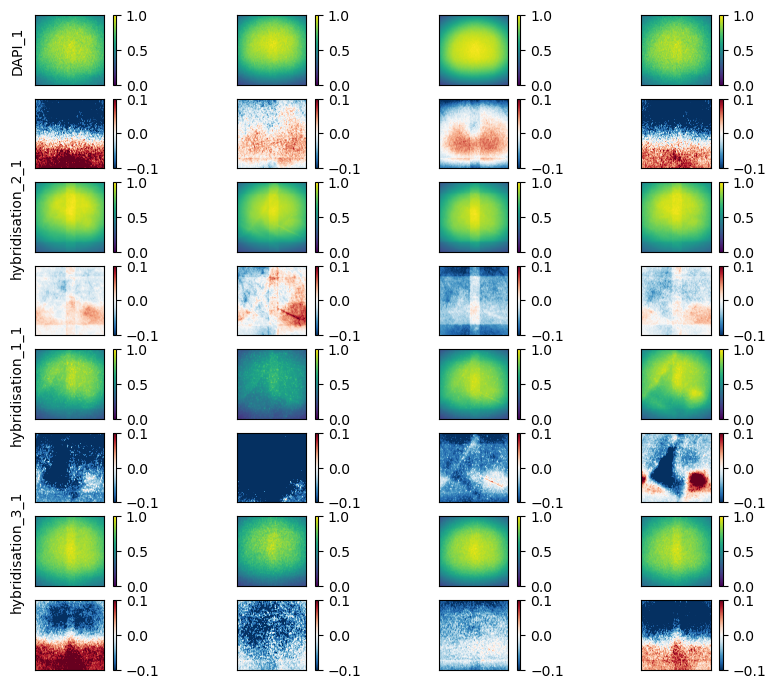

In [5]:
# Generate diagnostic plot
from iss_preprocess.pipeline import diagnostic
# it takes about 2 minutes to run and save all images
diagnostic.check_illumination_correction(
    data_path, grand_averages=("barcode_round", "genes_round"), verbose=False
)


# Estimate registration for rounds and channels

In [ ]:
pixel_dist, norm_factors = iss.pipeline.estimate_channel_correction(
    data_path, 
    prefix="barcode_round", 
    nrounds=ops["barcode_rounds"]
)
save_path = processed_path / data_path / 'correction_barcode_round.npz'
np.savez(save_path, pixel_dist=pixel_dist, norm_factors=norm_factors)

pixel_dist, norm_factors = iss.pipeline.estimate_channel_correction(
    data_path, 
    prefix="genes_round",
    nrounds=ops["genes_rounds"])
save_path = processed_path / data_path / 'correction_genes_round.npz'
np.savez(save_path, pixel_dist=pixel_dist, norm_factors=norm_factors)

iss.pipeline.estimate_channel_correction_hybridisation(data_path)

Start a registration jobs for the reference tile for genes and barcodes:

`sbatch --export=DATAPATH=becalia_rabies_barseq/BRYC65.1d/chamber_13/,PREFIX=genes_round register_ref_tile.sh`

`sbatch --export=DATAPATH=becalia_rabies_barseq/BRYC65.1d/chamber_13/,PREFIX=barcode_round register_ref_tile.sh`

Next, estimate shifts for individual tiles:

`iss estimate-shifts -p becalia_rabies_barseq/BRYC65.1d/chamber_13/ -n barcode_round`

`iss estimate-shifts -p becalia_rabies_barseq/BRYC65.1d/chamber_13/ -n genes_round`

Finally, calculate robust regression corrected shifts:

`iss correct-shifts -p becalia_rabies_barseq/BRYC65.1d/chamber_13/ -n barcode_round`

`iss correct-shifts -p becalia_rabies_barseq/BRYC65.1d/chamber_13/ -n genes_round`

# Prepare parameters for OMP and barcode calling

In [ ]:
stack, bad_pixels = iss.pipeline.load_and_register_tile(
    data_path, 
    ops['ref_tile'], 
    filter_r=ops['filter_r'], 
    prefix='genes_round',
    suffix=ops['projection'], 
    correct_channels=True
)
stack = stack[:, :, np.argsort(ops['camera_order']), :]
gene_dict, gene_names, norm_shift = iss.pipeline.setup_omp(
    stack, 
    detection_threshold=ops['detection_threshold'], 
    isolation_threshold=ops['isolation_threshold'],
    codebook_name=ops['codebook']
)
save_path = processed_path / data_path / 'gene_dict.npz'
np.savez(save_path, gene_dict=gene_dict, gene_names=gene_names, norm_shift=norm_shift)

In [ ]:
cluster_means, rois = iss.pipeline.setup_barcode_calling(
    data_path, score_thresh=0.5, correct_channels="round1_only")
save_path = processed_path / data_path / 'barcode_cluster_means.npy'
np.save(save_path, cluster_means)

# Check registration

In [ ]:
stack, bad_pixels = iss.pipeline.load_and_register_tile(
    data_path, 
    (2, 4, 9), 
    filter_r=ops['filter_r'], 
    prefix='barcode_round',
    suffix=ops['projection'],
    nrounds=ops['barcode_rounds'],
    correct_channels=True,
    corrected_shifts=True,
    correct_illumination=True
)
stack = stack[:, :, np.argsort(ops['camera_order']), :]
nrounds = stack.shape[3]
channel_colors = [ [1,0,0], [0,1,0], [0,1,1], [1,0,1]]
def round_image(iround):
    vmax = 3
    return iss.vis.to_rgb(
        stack[501:1000, 1501:2000, :, iround], 
        channel_colors, 
        vmin=np.array([0,0,0,0]),
        vmax=np.array([1,1,1,1]) * vmax)

fig = plt.figure(figsize=(10,8))
for iround in range(nrounds):
    plt.subplot(3,4,iround+1)
    plt.imshow(round_image(iround))
    plt.axis('off')
plt.tight_layout()

In [ ]:
%matplotlib ipympl
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
im = ax1.imshow(round_image(0))

def animate(frame_num):
    im.set_data(round_image(frame_num))
    ax1.set_title(f'round {frame_num}')
    return im

anim = FuncAnimation(fig, animate, frames=nrounds, interval=2000)
plt.show()

# Re-compute average spot image

Run OMP on the reference tile and detect spots to generate a new spot sign image.

Inspect OMP output to check parameters.

In [ ]:
g, b, r = iss.call.run_omp(
    np.moveaxis(stack, 2, 3),
    gene_dict,
    tol=ops['omp_threshold'],
    weighted=True,
    refit_background=True,
    alpha=ops["omp_alpha"],
    norm_shift=norm_shift,
    max_comp=ops["omp_max_genes"],
    min_intensity=ops['omp_min_intensity'],
)

spot_sign_image = iss.call.get_spot_shape(g, spot_xy=7, neighbor_filter_size=9, neighbor_threshold=15)
spot_sign_image = iss.call.apply_symmetry(spot_sign_image)
save_path = processed_path / data_path / 'spot_sign_image.npy'
np.save(save_path, spot_sign_image)
plt.figure(figsize=(3,3))
plt.imshow(spot_sign_image, cmap='bwr', vmin=-1, vmax=1)

plt.figure(figsize=(10,80))
for i in range(len(gene_names)):
    plt.subplot(30,3,i+1)
    plt.imshow(g[:200, :200, i], cmap='bwr', vmin=-1, vmax=1)
    plt.title(gene_names[i])
plt.tight_layout()

# Check barcode threshold

In [ ]:
stack, bad_pixels = iss.pipeline.load_and_register_tile(
    data_path,
    ops["ref_tile"],
    filter_r=ops["filter_r"],
    prefix="barcode_round",
    suffix=ops["projection"],
    nrounds=10,
    correct_channels=ops["barcode_correct_channels"],
    corrected_shifts=True,
    correct_illumination=True,
)
spots = iss.segment.detect_spots(np.mean(stack, axis=(2,3)), threshold=0.1)
plt.figure(figsize=(10,10))
plt.imshow(np.mean(stack, axis=(2,3)), cmap='bwr', vmin=-.1, vmax=.1)
plt.plot(spots["x"], spots["y"], '.k', markersize=0.5)

# Run OMP
Run `iss extract` to start Slurm jobs to run OMP on each tile:

`iss extract -p becalia_rabies_barseq/BRYC65.1d/chamber_13/`

# Run basecalling

`iss basecall -p becalia_rabies_barseq/BRYC65.1d/chamber_13/`

Then merge barcodes across tiles and align to gene rounds:

`iss align-spots -p becalia_rabies_barseq/BRYC65.1d/chamber_13/ -s barcode_round -g barcode_round_1_1`


# Merge OMP output

In [ ]:
shift_right, shift_down, tile_shape = iss.pipeline.register_adjacent_tiles(
    data_path, ref_coors=ops['ref_tile'], prefix='genes_round_1_1'
)
for iroi in range(8):
    spots = iss.pipeline.merge_roi_spots(data_path, shift_right, shift_down, tile_shape, iroi=iroi+1)
    save_path = Path(PARAMETERS['data_root']['processed']) / data_path / f'gene_spots_{iroi+1}.pkl' 
    spots.to_pickle(save_path)

# Plot some barcodes and genes

In [ ]:
import pandas as pd
all_spots = []
genes_spots = []
for i, roi in enumerate(ops["use_rois"]):
    save_path = processed_path / data_path / f'barcode_round_spots_{roi}.pkl' 
    these_spots = pd.read_pickle(save_path)
    these_spots["roi"] = roi
    all_spots.append(these_spots)
    these_spots = pd.read_pickle(processed_path / data_path / f'gene_spots_{roi}.pkl' )
    these_spots["roi"] = roi
    genes_spots.append(these_spots)

spots = pd.concat(all_spots, ignore_index=True)
genes_spots = pd.concat(genes_spots, ignore_index=True)

In [ ]:
spots = iss.call.correct_barcode_sequences(
    spots[spots["dot_product_score"]>0.25], 
    max_edit_distance=1
)

from itertools import cycle
from matplotlib import rcParams
plt.style.use("default")

fig = plt.figure(figsize=(20, 40), dpi=300)
fig.patch.set_facecolor('black')

sequence_counts = spots['corrected_bases'].value_counts()
xmax = spots['x'].max()
ymax = spots['y'].max()
genes = genes_spots['gene'].unique()
prop_cycle = plt.rcParams['axes.prop_cycle']
rois = genes_spots['roi'].unique()
genes_to_plot = [ 'Crym', 'Ctgf', 'Igfbp4', 'Lamp5' ,'Lypd1', 'Npy', 'Rgs4', 'Necab1', 'Cck', 'Myl4' ,'Th']
for iseq, seq in enumerate(sequence_counts.index[:8]):
    plt.subplot(10,1,iseq+1)
    plt.title(seq, color='white')
    plt.gca().set_aspect('equal', 'box')
    plt.gca().set_facecolor('black')
    colors = cycle(['deepskyblue', 'darkorange', 'forestgreen', 'royalblue', 'magenta', 'coral', 'gold', 'mediumorchid', 'red', 'lawngreen'])

    # for gene in genes_to_plot:
    #     c = next(colors)
    #     alpha = np.min([ 1e5 / np.sum(genes_spots['gene']==gene), 0.2 ])
    #     for iroi, roi in enumerate(rois):            
    #         plt.plot(
    #             genes_spots[(genes_spots['gene']==gene) & (genes_spots['roi']==roi)]['x'] + iroi*60000,
    #             genes_spots[(genes_spots['gene']==gene) & (genes_spots['roi']==roi)]['y'],
    #             ',',
    #             c=c,  
    #             alpha=alpha,
    #         )   
    for iroi, roi in enumerate(rois):    
        this_barcode = spots[(spots['corrected_bases'] == seq) & (spots['roi']==roi)]
        plt.plot(
            this_barcode['x'] + iroi*60000,
            this_barcode['y'],        
            's',
            markersize=0.2,
            c='white',
        )
    plt.axis('off')
    plt.gca().invert_yaxis()
    plt.tight_layout()

# Generate an overview image and segment cells

Test segmentation parameters:


In [ ]:
roi = 1
stitched_stack_dapi, stitched_stack_genes, angle, shift = iss.pipeline.stitch_and_register(
    data_path, 'genes_round_1_1', 'DAPI_1', roi=roi, downsample=5
)

In [ ]:
masks = np.load(processed_path / data_path / "masks_1.npy")
im = np.stack([
    stitched_stack_genes[3000:10000, 12000:20000], 
    stitched_stack_dapi[3000:10000, 12000:20000],
    masks[3000:10000, 12000:20000]>0],
    axis=2
)
shift_right, shift_down, tile_shape = iss.pipeline.register_adjacent_tiles(
    data_path, ref_coors=ops['ref_tile'], prefix='genes_round_1_1'
)
spots = iss.pipeline.merge_roi_spots(
    data_path, shift_right, shift_down, tile_shape, iroi=roi, prefix="genes_round"
)
plt.figure(figsize=(50,50))
plt.imshow(iss.vis.to_rgb(im, colors=[[1,0,0], [0,0,1], [0, 1, 0]], vmax=[400, 200, 1], vmin=np.array([30, 0, 0])))
plt.plot(spots["x"]-12000, spots["y"]-3000, '.r', alpha=1, markersize=0.5)
plt.xlim([0, 8000])
plt.ylim([7000, 0])
plt.axis("off")

In [ ]:
from cellpose.models import CellposeModel
from cellpose.plot import mask_rgb

model = CellposeModel(gpu=True, model_type='cyto', net_avg=False)
masks, flows, styles = model.eval(
    stitched_stack_dapi[11000:12000, 5000:6000],
    rescale=0.55,
    channels=[0,0],
    flow_threshold=0.4,
    tile=True
)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(stitched_stack_dapi[11000:12000, 5000:6000], vmax=1000)
plt.subplot(1,2,2)
plt.imshow(mask_rgb(masks))

# Run batch segmentation:

`iss segment-all -p $DATAPATH -n $PREFIX`

# Align hybridisation rounds
To run all hybridisation rounds listed in metadata:

`iss estimate-hyb-shifts -p becalia_rabies_barseq/BRYC65.1d/chamber_13/`

`iss correct_hyb_shifts -p becalia_rabies_barseq/BRYC65.1d/chamber_13/`

To run a specific round, e.g. anchor round:

`iss estimate-hyb-shifts -p becalia_rabies_barseq/BRYC65.1d/chamber_13/ -n hybridisation_3_1`

`iss correct_hyb_shifts -p becalia_rabies_barseq/BRYC65.1d/chamber_13/ -n hybridisation_3_1`


In [ ]:
iss.pipeline.setup_hyb_spot_calling(data_path)

# Check hyb spot detection threshold

In [ ]:
stack, bad_pixels = iss.pipeline.load_and_register_hyb_tile(
    data_path,
    tile_coors=ops["ref_tile"],
    prefix="hybridisation_2_1",
    suffix="max",
    correct_illumination=True,
    correct_channels=True
)

spots = iss.segment.detect_spots(
    np.max(stack, axis=2),
    threshold=0.5
)
plt.figure(figsize=(20,20))
plt.imshow(np.max(np.abs(stack), axis=2), vmax=1, vmin=-1, cmap='bwr')
plt.plot(spots['x'], spots['y'], '.', c='k', markersize=3, alpha=0.5)
# plt.xlim([1000,2000])
# plt.ylim([1000,2000])


# Detect hybridisation spots in all tiles

`iss hyb-spots -p becalia_rabies_barseq/BRYC65.1d/chamber_13/`

`iss align-spots -p becalia_rabies_barseq/BRYC65.1d/chamber_13/ -s hybridisation_1_1 -g hybridisation_1_1`

`iss align-spots -p becalia_rabies_barseq/BRYC65.1d/chamber_13/ -s hybridisation_2_1 -g hybridisation_2_1`
